## Estimaciones del Modelo

### Importación de Librerías

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import joblib
from sklearn.metrics import accuracy_score
import nltk
nltk.download('vader_lexicon')
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment import SentimentIntensityAnalyzer
pd.set_option('display.max_columns', None)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from pydantic import BaseModel
from typing import List, Union, Tuple , Optional
from fastapi import FastAPI, HTTPException, Depends, Query

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ozi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Precisión en los datos de nuevos datos

In [20]:
# Cargar los datos de prueba (o los datos que quieras predecir)

X_test= pd.read_csv('../datasets/processed/X_test.csv', sep=',', encoding='utf-8')
y_test= pd.read_csv('../datasets/processed/y_test.csv', sep=',', encoding='utf-8')


In [21]:
X_test.head(5)

,genres_str,app_name,release_date,price,game_id,developer,year,user_id,user_reviews_item_id,review,posted_date,items_count,steam_id,users_items_item_id,item_name,playtime_forever,playtime_2weeks
0,adventure,METAL GEAR SOLID V: THE PHANTOM PAIN,2015-09-01,19.99,287700,Konami Digital Entertainment,2015,LucarioSakaki,287700,DLC confirmed,2015-09-13,373,76561197972244272,287700,METAL GEAR SOLID V: THE PHANTOM PAIN,2913,0
1,freetoplay,Portal Stories: Mel,2015-06-25,-1.00,317400,Prism Game Studios Ltd.,2015,76561198059399607,317400,Amazing game.10/10 on the Story 6/10 on gamepl...,2015-07-17,62,76561198059257611,317400,Portal Stories: Mel,200,0
2,rpg,The Ship: Murder Party,2006-07-11,9.99,2400,Outerlight Ltd.,2006,nnotzsb,2400,Play this game. Has only 2 choice for me but i...,2013-12-20,28,76561198059284546,2400,The Ship,0,0
3,adventure,Just Cause 2,2010-03-23,14.99,8190,Avalanche Studios,2010,AquaLazor,8190,Pros+Graphics are nice+Runs on Intel HD Family...,2015-08-03,35,76561198059288278,8190,Just Cause 2,262,0
4,strategy,Darkwind: War on Wheels,2014-08-22,-1.00,295710,Psychic Software,2014,76561198195842698,295710,just pooo,2015-12-10,2316,76561197998887921,295710,Darkwind: War on Wheels,0,0


In [22]:
y_test.head(5)

,recommend
0,1
1,1
2,1
3,1
4,0


In [23]:
class SentimentAnalysisProcessor:
    def __init__(self, threshold_low=-0.5, threshold_high=0.5):
        self.threshold_low = threshold_low
        self.threshold_high = threshold_high
        self.analyzer = SentimentIntensityAnalyzer()

    def process_data(self, input_df):
        # Crear una copia del DataFrame de entrada para evitar modificaciones no deseadas
        allowed_genres = ['strategy', 'indie', 'rpg', 'action', 'simulation', 'adventure']
        df_a = input_df[input_df['genres_str'].isin(allowed_genres)]
        df = df_a.copy()

        # Aplicar el análisis de sentimientos a la columna 'review'
        df['scores_review'] = df['review'].apply(lambda x: self.analyzer.polarity_scores(x)['compound'])

        # Crear la nueva columna 'score_new' según las bandas definidas
        df['score_new'] = df['scores_review'].apply(lambda x: 0 if x < self.threshold_low else (2 if x > self.threshold_high else 1))

        # Clasificar las reseñas numéricamente
        df['sentiment_numeric'] = df['score_new']

        # Clasificar las reseñas como "Positive", "Negative" o "Neutral"
        df['sentiment_more_less'] = df['score_new'].apply(lambda x: 'Positive' if x == 2 else ('Negative' if x == 0 else 'Neutral'))

        # Eliminar las columnas 'review' y 'scores_review' si es necesario
        columns_to_drop = ['review', 'scores_review', 'release_date', 'posted_date', 'item_name', 'sentiment_numeric','user_reviews_item_id','user_id','users_items_item_id']
        df = df.drop(columns=columns_to_drop)
        df['steam_id'] = df['steam_id'].astype('object')
        df['game_id'] = df['game_id'].astype('object')
        return df

# Crear una instancia de la clase
sentiment_processor = SentimentAnalysisProcessor()

In [24]:
concat_df2 = pd.concat([X_test, y_test], axis=1)
output_df_test = sentiment_processor.process_data(concat_df2)

In [25]:
# Definir la clase MultiColumnLabelEncoder
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        for col in self.columns:
            le = self.label_encoders[col]
            X.loc[:, col] = le.transform(X[col])
        return X

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_columns = []
        self.ordinal_columns = []
        self.categorical_columns = []

    def fit(self, X, y=None):
        # Obtener las columnas numéricas, ordinales y categóricas
        self.numeric_columns = X.select_dtypes(include=['int64', 'float64', 'int32']).columns
        self.ordinal_columns = ['recommend']  # Puedes añadir aquí tus columnas ordinales
        self.categorical_columns = X.select_dtypes(include=['object']).columns
        return self

    def transform(self, X):
        # Crear una nueva variable excluyendo las columnas ordinales
        categorical_col_excluded_ordinal = [col for col in self.categorical_columns if col not in self.ordinal_columns]
        numeric_col_excluded_ordinal = [col for col in self.numeric_columns if col not in self.ordinal_columns]

        # Convertir las columnas categóricas a tipo str
        X.loc[:, categorical_col_excluded_ordinal] = X[categorical_col_excluded_ordinal].astype(str)

        # Definir las transformaciones para las columnas numéricas
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        # Definir las transformaciones para las columnas ordinales
        ordinal_transformer = MultiColumnLabelEncoder(columns=self.ordinal_columns)

        # Aplicar las transformaciones
        transformed_data = numeric_transformer.fit_transform(X[numeric_col_excluded_ordinal])
        transformed_data = np.concatenate([transformed_data, ordinal_transformer.fit_transform(X[self.ordinal_columns])], axis=1)

        # Obtener los nombres de las columnas después de la transformación
        numeric_feature_names = numeric_transformer.named_steps['scaler'].get_feature_names_out(input_features=numeric_col_excluded_ordinal)
        ordinal_feature_names = self.ordinal_columns
        column_names = np.concatenate([numeric_feature_names, ordinal_feature_names])

        return transformed_data, column_names



def process_dataframe(input_df: pd.DataFrame, columns_to_drop: list) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    # Create an instance of the class
    label_processor = MultiColumnLabelEncoder() 
    custom_processor = CustomPreprocessor()

    # Drop specified columns
    processed_df = input_df.drop(columns=columns_to_drop)

    # Apply the pipeline to the DataFrame
    transformed_data, column_names = custom_processor.fit_transform(processed_df)

    return processed_df, pd.DataFrame(transformed_data, columns=column_names)

# Example usage
columns_to_drop = ['app_name','game_id' , 'developer', 'steam_id', 'sentiment_more_less']
processed_df, transformed_df_test = process_dataframe(output_df_test, columns_to_drop)

In [26]:
transformed_df_test.head(5)


,price,year,items_count,playtime_forever,playtime_2weeks,score_new,recommend
0,0.340073,0.765206,0.436702,-0.132357,-0.102128,-0.640026,1.0
1,-0.412331,-1.573846,-0.470005,-0.397643,-0.102128,0.933161,1.0
2,-0.036129,-0.534267,-0.451608,-0.373783,-0.102128,-0.640026,1.0
3,-1.239223,0.505312,5.543177,-0.397643,-0.102128,-0.640026,0.0
4,-1.239223,1.284996,-0.341227,-0.393545,-0.102128,0.933161,1.0


In [27]:
# Definir la variable objetivo "recommend" codificada
y_test = transformed_df_test[['recommend']]

# Seleccionar el resto de las columnas (variables predictoras) y eliminar la columna
X_test= transformed_df_test.drop(columns=['recommend'])

In [28]:

# Cargar el modelo desde el archivo
modelo_guardado = joblib.load('../datasets/models/mejor_modelo_decision_tree.joblib')

# Hacer predicciones en los datos de prueba
y_pred_prueba = modelo_guardado.predict(X_test)

# Calcular la precisión en los datos de prueba
precision_prueba = accuracy_score(y_test, y_pred_prueba)
print(f'Precisión en los datos de prueba: {precision_prueba:.2%}')

Precisión en los datos de prueba: 78.08%


### Reporte de características, predicciones y etiquetas reales

In [29]:
# Cargar el modelo desde el archivo
modelo_guardado = joblib.load('../datasets/models/mejor_modelo_decision_tree.joblib')

# Hacer predicciones en los datos de prueba
y_pred_prueba = modelo_guardado.predict(X_test)

# Convertir las predicciones a un DataFrame
resultados_detalles = pd.DataFrame({'Predicciones': y_pred_prueba})

# Concatenar las características de X_test al DataFrame de predicciones
resultados_detalles = pd.concat([X_test, resultados_detalles], axis=1)

# Mostrar las primeras filas del DataFrame
#resultados_detalles.head(5)


# Convertir las predicciones y etiquetas reales a arrays unidimensionales
y_pred_prueba_unidimensional = np.ravel(y_pred_prueba)
y_test_unidimensional = np.ravel(y_test)

# Crear un DataFrame con características, predicciones y etiquetas reales
resultados_detalles = pd.concat([X_test, pd.Series(y_pred_prueba_unidimensional, name='Predicciones'), pd.Series(y_test_unidimensional, name='Etiquetas Reales')], axis=1)

# Mostrar las primeras filas del DataFrame
resultados_detalles.head(15)


,price,year,items_count,playtime_forever,playtime_2weeks,score_new,Predicciones,Etiquetas Reales
0,0.340073,0.765206,0.436702,-0.132357,-0.102128,-0.640026,1,1.0
1,-0.412331,-1.573846,-0.470005,-0.397643,-0.102128,0.933161,1,1.0
2,-0.036129,-0.534267,-0.451608,-0.373783,-0.102128,-0.640026,1,1.0
3,-1.239223,0.505312,5.543177,-0.397643,-0.102128,-0.640026,0,0.0
4,-1.239223,1.284996,-0.341227,-0.393545,-0.102128,0.933161,1,1.0
5,-0.412331,0.245417,-0.094182,-0.365404,-0.102128,0.933161,1,1.0
6,1.092477,0.245417,-0.467377,-0.352837,-0.102128,-0.640026,1,1.0
7,-0.036129,1.025101,-0.451608,-0.197198,-0.102128,-0.640026,1,1.0
8,-0.412331,0.245417,-0.356995,-0.394547,-0.102128,-2.213214,1,1.0
9,1.092477,0.765206,-0.438468,0.612412,-0.102128,0.933161,1,1.0


### Importancia de Características en el Modelo

              precision    recall  f1-score   support

         0.0       0.21      0.44      0.28       762
         1.0       0.93      0.82      0.87      6993

    accuracy                           0.78      7755
   macro avg       0.57      0.63      0.58      7755
weighted avg       0.86      0.78      0.81      7755



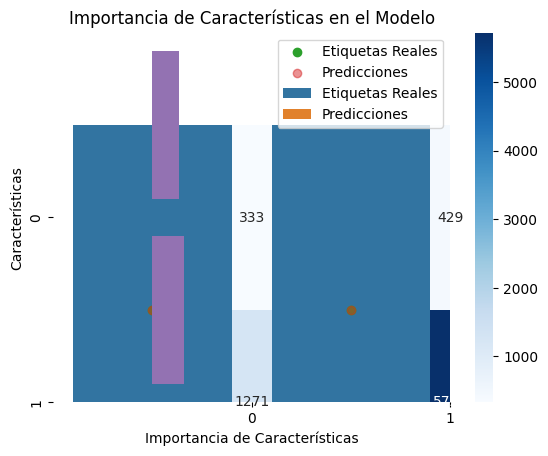

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
resultados= resultados_detalles
# ... (código previo)

# Matriz de Confusión
conf_matrix = confusion_matrix(resultados['Etiquetas Reales'], resultados['Predicciones'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Gráfico de Barras - Distribución de Clases
sns.countplot(x='Etiquetas Reales', data=resultados, label='Etiquetas Reales')
sns.countplot(x='Predicciones', data=resultados, label='Predicciones')
plt.legend()

# Diagrama de dispersión
plt.scatter(resultados.index, resultados['Etiquetas Reales'], label='Etiquetas Reales')
plt.scatter(resultados.index, resultados['Predicciones'], label='Predicciones', alpha=0.5)
plt.legend()

# Reporte de Clasificación
print(classification_report(resultados['Etiquetas Reales'], resultados['Predicciones']))

# Visualización de Características Importantes (si están disponibles en tu modelo)
if hasattr(modelo_guardado, 'feature_importances_'):
    feature_importance = modelo_guardado.feature_importances_
    feature_names = X_test.columns  # Asegúrate de utilizar las columnas correctas
    sns.barplot(x=feature_importance, y=feature_names)
    plt.xlabel('Importancia de Características')
    plt.ylabel('Características')
    plt.title('Importancia de Características en el Modelo')

plt.show()



### Diagrama de Dispersión de Etiquetas Reales vs. Predicciones

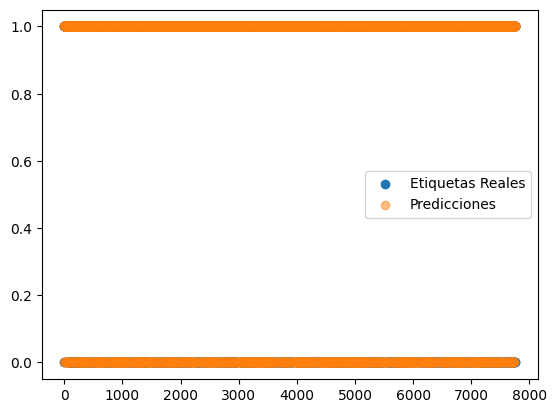

In [31]:
# Diagrama de dispersión
plt.scatter(resultados.index, resultados['Etiquetas Reales'], label='Etiquetas Reales')
plt.scatter(resultados.index, resultados['Predicciones'], label='Predicciones', alpha=0.5)
plt.legend()

### Relación entre Etiquetas Reales y Predicciones (KDE)

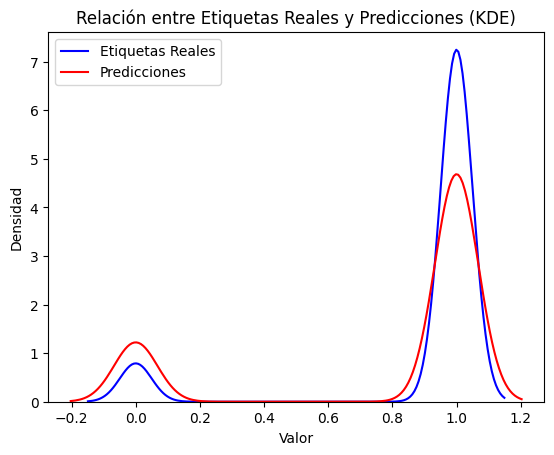

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico KDE para Etiquetas Reales
sns.kdeplot(resultados['Etiquetas Reales'], label='Etiquetas Reales', color='blue')

# Gráfico KDE para Predicciones
sns.kdeplot(resultados['Predicciones'], label='Predicciones', color='red')

plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Relación entre Etiquetas Reales y Predicciones (KDE)')
plt.legend()
plt.show()



### Característica de Operación del Receptor para cada clase

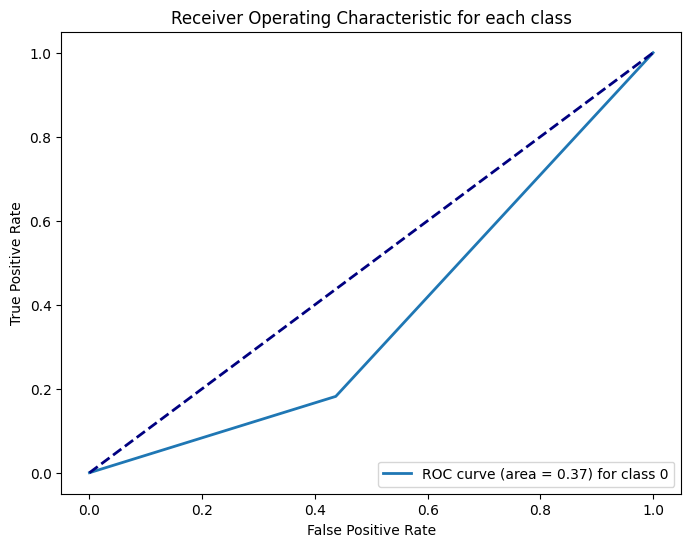

In [33]:
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Crear un DataFrame con características, predicciones y etiquetas reales
resultados_detalles = pd.concat([X_test, pd.Series(y_pred_prueba_unidimensional, name='Predicciones'), pd.Series(y_test_unidimensional, name='Etiquetas Reales')], axis=1)

# Binarizar las etiquetas para poder calcular la curva ROC y AUC
y_test_binario = label_binarize(resultados_detalles['Etiquetas Reales'], classes=np.unique(resultados_detalles['Etiquetas Reales']))

# Calcular la curva ROC y AUC para cada clase
n_classes = y_test_binario.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binario[:, i], resultados_detalles['Predicciones'] == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotear la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


### Importancia de Características en el Modelo

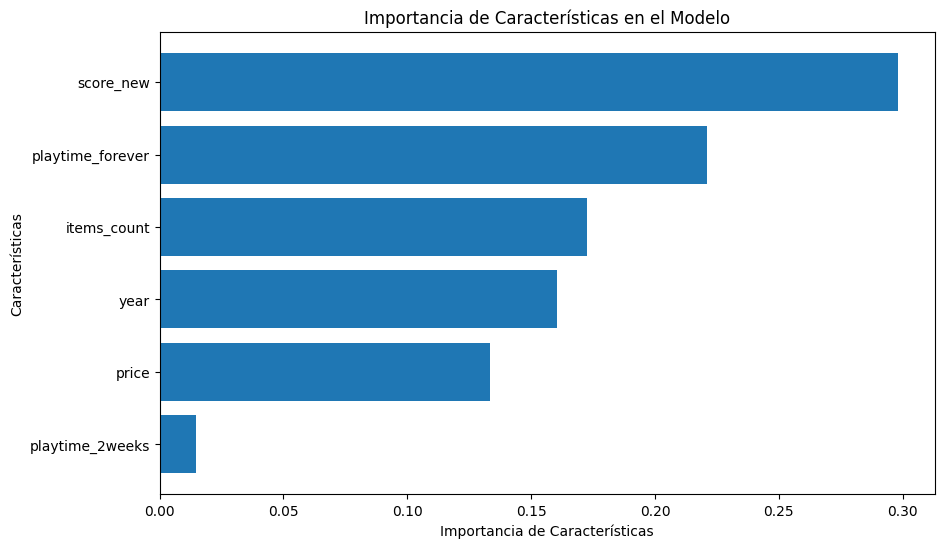

In [34]:
if hasattr(modelo_guardado, 'feature_importances_'):
    feature_importance = modelo_guardado.feature_importances_
    feature_names = X_test.columns  # Asegúrate de que estas sean las mismas columnas que usaste durante el entrenamiento
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    plt.xlabel('Importancia de Características')
    plt.ylabel('Características')
    plt.title('Importancia de Características en el Modelo')
    plt.show()


### Gráfico de Barras - Distribución de Clases

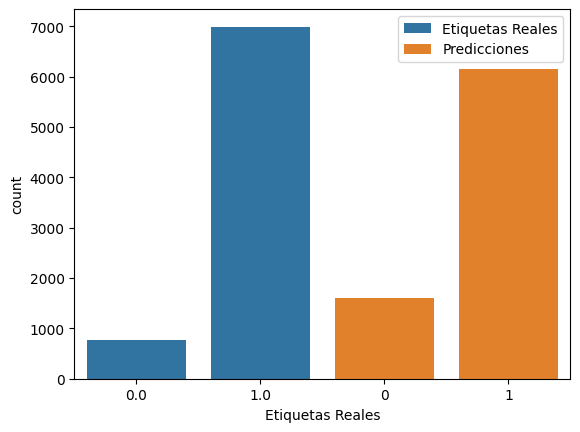

In [35]:


sns.countplot(x='Etiquetas Reales', data=resultados, label='Etiquetas Reales')
sns.countplot(x='Predicciones', data=resultados, label='Predicciones')
plt.legend()